In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

from statsmodels.tsa.stattools import kpss
from statsmodels.compat import lzip
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
# We want to investigate: are the time series stationary? If not, can we transform them to make them stationary?
# Check KPSS test, Augmented Dickey-Fuller test.
# If a trend is evident, difference the data to remove it and then check if the differenced data is stationary.

In [3]:
chill = pd.read_csv('data_csvs/everest_8000m_chill_time_series.csv')
chill.insert(loc=0, column='time', value=chill.index.to_numpy()*8)
chill.drop(columns=['local_time_of_forecast (Date Hour)'], inplace=True)

In [4]:
# Checking for stationarity around a constant:
kpss_chill = kpss(chill['chill'], regression='c')
print('KPSS test: chill around a constant')
names = ['KPSS test statistic', 'p-value', 'truncation lag parameter', 'critical values']
lzip(names, kpss_chill)

KPSS test: chill around a constant


C:\Users\pmwad\AppData\Local\Temp\ipykernel_14904\1989173959.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_chill = kpss(chill['chill'], regression='c')


[('KPSS test statistic', 1.0561402869480614),
 ('p-value', 0.01),
 ('truncation lag parameter', 8),
 ('critical values', {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})]

In [5]:
# The critical value is <<< 0.05, so we reject the null hypothesis that the data are stationary around a constant.

In [6]:
# Checking for stationarity around a trend:
kpss_chill = kpss(chill['chill'], regression='ct')
print('KPSS test: chill around a trend')
names = ['KPSS test statistic', 'p-value', 'truncation lag parameter', 'critical values']
lzip(names, kpss_chill)

KPSS test: chill around a trend


[('KPSS test statistic', 0.12328837986735758),
 ('p-value', 0.09205855580118966),
 ('truncation lag parameter', 8),
 ('critical values', {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})]

In [7]:
# So, apparently the data can be considered to be stationary around a trend.

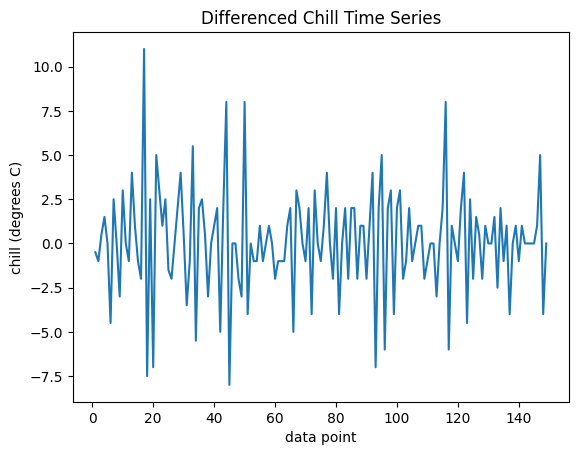

In [8]:
# Can we remove the trend in order to obtain an apparently stationary time series?
# To start, let's attempt to difference the time series. 
chill_diff = chill['chill'].diff()[1:]  # Remove the first data point since it is NaN
chill_diff.plot()
plt.title('Differenced Chill Time Series')
plt.xlabel('data point')
plt.ylabel('chill (degrees C)')
plt.show()

In [9]:
# The data remind me of our plot of the residuals that we obtained after perfoming a Classical Decomposition of this time series.
# It certainly looks like the trend has been removed.
# Let's check the stationarity now by KPSS test.
kpss_chill_diff = kpss(chill_diff, regression='c')
print('KPSS test: chill around a constant')
names = ['KPSS test statistic', 'p-value', 'truncation lag parameter', 'critical values']
lzip(names, kpss_chill_diff)

KPSS test: chill around a constant


C:\Users\pmwad\AppData\Local\Temp\ipykernel_14904\2386963338.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_chill_diff = kpss(chill_diff, regression='c')


[('KPSS test statistic', 0.07308937882284025),
 ('p-value', 0.1),
 ('truncation lag parameter', 11),
 ('critical values', {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})]

In [10]:
# The p-value has increased to above 10%, indicating that the data are stationary around a constant now.

In [11]:
# Out of curiosity, is the variance constant with time here? Breusch-Pagan test can shed light on this.
chill_diff_df = pd.DataFrame(chill_diff)
print('Mean of the residuals: ' + str(chill_diff_df.mean(axis=0)) + '\n')
chill_diff_df.insert(loc=0, column='index', value=chill_diff_df.index.to_numpy())
bp_fit = smf.ols('chill ~ index', data=chill_diff_df).fit()
print(bp_fit.summary())

names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_result = sms.het_breuschpagan(bp_fit.resid, bp_fit.model.exog)
lzip(names, bp_result)

Mean of the residuals: chill    0.097315
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                  chill   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.02464
Date:                Thu, 08 Aug 2024   Prob (F-statistic):              0.875
Time:                        12:44:33   Log-Likelihood:                -373.35
No. Observations:                 149   AIC:                             750.7
Df Residuals:                     147   BIC:                             756.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

[('Lagrange multiplier statistic', 3.496973973812157),
 ('p-value', 0.06148107126823792),
 ('f-value', 3.5329517755724735),
 ('f p-value', 0.06213974013304115)]

In [12]:
# Mean is approximately 0. Linear regression results in a flat model with R2 of 0.0. 
# Breusch-Pagan gives a p-value of just about 0.05, indicating we retain the null hypothesis that the data are homoscedastic.

In [13]:
# To cover our bases, let's do an Augmented Dickey-Fuller (ADF) test. Considering that we see autocorrelation in the data, it is certainly better to use the ADF than DF test.
# Here, I have left the default option to use the Akaike Information Criterion (AIC) to optimize the lag length.
adf_chill_diff = adfuller(chill_diff_df['chill'])
print('Augmented Dickey-Fuller test: differenced chill data')
names = ['ADF test statistic', 'p-value', '# of lags used', '# observations', 'critical values', 'maximized information criterion']
lzip(names, adf_chill_diff)

Augmented Dickey-Fuller test: differenced chill data


[('ADF test statistic', -8.57451842108926),
 ('p-value', 8.030115856008396e-14),
 ('# of lags used', 4),
 ('# observations', 144),
 ('critical values',
  {'1%': -3.476597917537401,
   '5%': -2.8818291230495543,
   '10%': -2.5775887982253085}),
 ('maximized information criterion', 627.9185672535466)]

In [14]:
# The p-value from the ADF test is very low, so we can confidently reject the null hypothesis that there is a unit root.
# Thus, we can be confident that the differenced chill data is stationary.
# The optimal lag length was found to be 4, which is maybe one more than I might have expected. Changing the number of lags does not seem to significantly impact the test results.

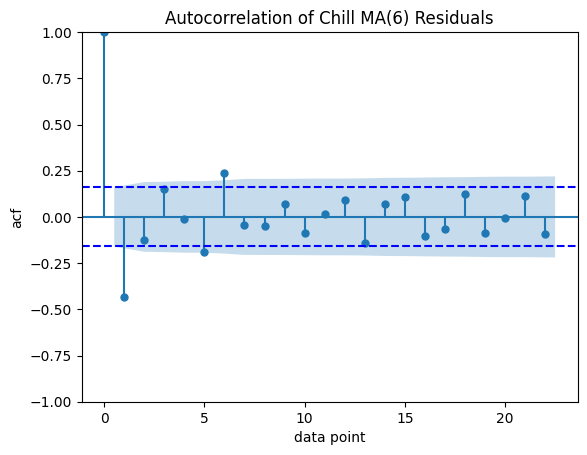

In [ ]:
# Now that we have apparently reached a stationary time series, I want to take a look into autocorrelation.
plot_acf(chill_diff_df['chill'], alpha=0.05)
plt.axhline(y=0.16, color='b', linestyle='--')
plt.axhline(y=-0.16, color='b', linestyle='--')
plt.title('Autocorrelation of Differenced Chill Time Series')
plt.xlabel('data point')
plt.ylabel('acf')
plt.show()

In [16]:
# Clearly there is autocorrelation at lag 1. Lags 3, 5 and 6 also stand out.

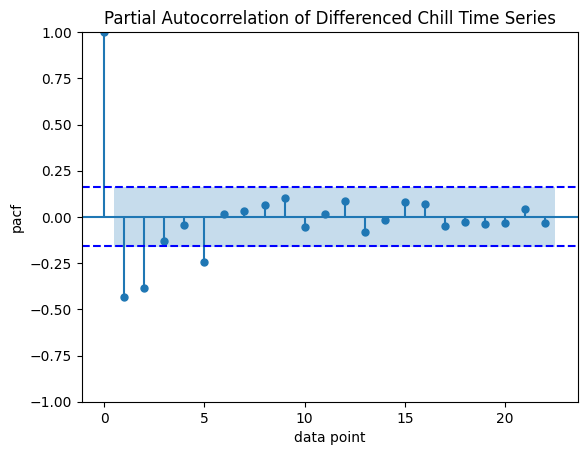

In [17]:
# Let's also check out the behavior of the PACF.
plot_pacf(chill_diff_df['chill'], alpha=0.05)
plt.axhline(y=0.16, color='b', linestyle='--')
plt.axhline(y=-0.16, color='b', linestyle='--')
plt.title('Partial Autocorrelation of Differenced Chill Time Series')
plt.xlabel('data point')
plt.ylabel('pacf')
plt.show()

In [18]:
# Here, the autocorrelations at lags of 1, 2, and 5 are significant. 
# In this case, I would say that neither the ACF nor the PACF show obvious tailing-off. Therefore, these data suggest an ARMA model for the differenced data.
# These plots suggest MA(1), MA(5) or MA(6); AR(1), AR(2) or AR(5).

In [19]:
# These data suggest that there is indeed still some autocorrelation information here.
# Let's also check the Ljung-Box test for autocorrelation.
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(chill_diff_df['chill'])

,lb_stat,lb_pvalue
1,28.835675,7.878646e-08
2,31.154256,1.717668e-07
3,34.686625,1.418846e-07
4,34.716601,5.311514e-07
5,40.406752,1.236270e-07
6,49.196131,6.811496e-09
7,49.474767,1.831339e-08
8,49.897747,4.275888e-08
9,50.679537,8.024381e-08
10,51.872663,1.204750e-07


In [20]:
# The low p-value means we must reject the null hypothesis. This result indicates autocorrelation. 
# As long as the autocorrelation pattern is constant, this can be consistent with stationarity.

<AxesSubplot:title={'center':'Chill Time Series Decomp. Residuals'}, xlabel='data point', ylabel='residual'>

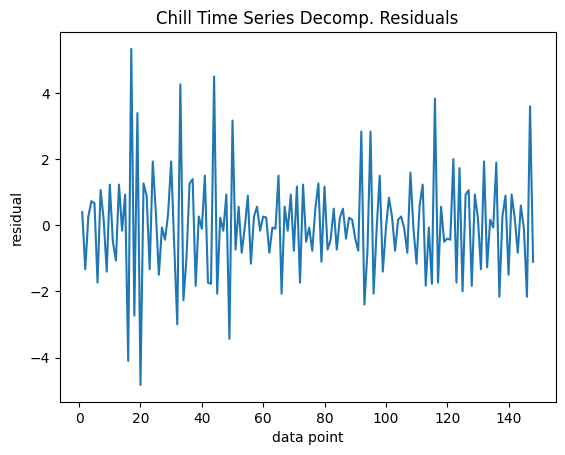

In [21]:
# Let's also take a look at the residuals from the Additive Classical Decomposition from the classical_decomp notebook:
chill_decomp = seasonal_decompose(x=chill['chill'], period=3, model='additive')
chill_decomp_residuals = chill_decomp.resid[1:149]
plt.title('Chill Time Series Decomp. Residuals')
plt.xlabel('data point')
plt.ylabel('residual')
chill_decomp_residuals.plot()

In [22]:
# KPSS test:
kpss_chill_decomp_residuals = kpss(chill_decomp_residuals, regression='c')
print('KPSS test: chill decomp. residuals around a constant')
names = ['KPSS test statistic', 'p-value', 'truncation lag parameter', 'critical values']
lzip(names, kpss_chill_decomp_residuals)

KPSS test: chill decomp. residuals around a constant


C:\Users\pmwad\AppData\Local\Temp\ipykernel_14904\72952856.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_chill_decomp_residuals = kpss(chill_decomp_residuals, regression='c')


[('KPSS test statistic', 0.26115285524870674),
 ('p-value', 0.1),
 ('truncation lag parameter', 67),
 ('critical values', {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})]

In [23]:
# Clearly this is well within the critical value for stationarity. 

In [24]:
# Let's also do ADF:
adf_chill_decomp_residuals = adfuller(chill_decomp_residuals)
print('Augmented Dickey-Fuller test: chill decomp. residuals')
names = ['ADF test statistic', 'p-value', '# of lags used', '# observations', 'critical values', 'maximized information criterion']
lzip(names, adf_chill_diff)

Augmented Dickey-Fuller test: chill decomp. residuals


[('ADF test statistic', -8.57451842108926),
 ('p-value', 8.030115856008396e-14),
 ('# of lags used', 4),
 ('# observations', 144),
 ('critical values',
  {'1%': -3.476597917537401,
   '5%': -2.8818291230495543,
   '10%': -2.5775887982253085}),
 ('maximized information criterion', 627.9185672535466)]

In [25]:
# The low p-value from this test is also consistent with stationarity. Thus, the differenced time series and decomposed time series for the chill data are both stationary.

In [26]:
wind = pd.read_csv('data_csvs/everest_8000m_wind_time_series.csv')
wind.insert(loc=0, column='time', value=wind.index.to_numpy()*8)
wind.drop(columns=['local_time_of_forecast (Date Hour)'], inplace=True)

In [27]:
# Checking for stationarity around a constant:
kpss_wind = kpss(wind['wind_speed'], regression='c')
print('KPSS test: wind speed around a constant')
names = ['KPSS test statistic', 'p-value', 'truncation lag parameter', 'critical values']
lzip(names, kpss_wind)

KPSS test: wind speed around a constant


[('KPSS test statistic', 0.44328244882111584),
 ('p-value', 0.05849894447365697),
 ('truncation lag parameter', 8),
 ('critical values', {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})]

In [28]:
# Here we retain the null hypothesis that the wind time series is stationary around a constant.

In [29]:
# Checking for stationarity around a trend:
kpss_wind = kpss(wind['wind_speed'], regression='ct')
print('KPSS test: wind speed around a trend')
names = ['KPSS test statistic', 'p-value', 'truncation lag parameter', 'critical values']
lzip(names, kpss_wind)

KPSS test: wind speed around a trend


[('KPSS test statistic', 0.14840118351157724),
 ('p-value', 0.04799901374035229),
 ('truncation lag parameter', 7),
 ('critical values', {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})]

In [30]:
# And the data do not appear to be stationary around a trend. 

In [31]:
# Let's add an Augmented Dickey-Fuller Test (ADF) to check that the wind speed data does not have a unit root, hopefully confirming the KPSS findings of stationarity.
adf_wind = adfuller(wind['wind_speed'])
print('Augmented Dickey-Fuller test: wind speed data')
names = ['ADF test statistic', 'p-value', '# of lags used', '# observations', 'critical values', 'maximized information criterion']
lzip(names, adf_wind)

Augmented Dickey-Fuller test: wind speed data


[('ADF test statistic', -3.276260810943253),
 ('p-value', 0.015973543796609726),
 ('# of lags used', 3),
 ('# observations', 146),
 ('critical values',
  {'1%': -3.4759527332353084,
   '5%': -2.881548071241103,
   '10%': -2.577438765246763}),
 ('maximized information criterion', 901.9847290653413)]

In [32]:
# The p-value is less than 0.05, so we reject the null hypothesis that there is a unit root. 
# Thus, the result of the ADF test is in agreement with the KPSS test for the wind speed data.
# The optimal lag length was found to be 3, which conforms to my expectations, since there are 3 observations per day.

# I am somewhat surprised that the wind speed data is apparently stationary, despite the apparent degree of autocorrelation. I suppose some autocorrelation is compatible with
# stationarity, especially if it dies out quickly enough (in terms of lag). 

In [41]:
# Let's just do a quick Breusch-Pagan test to see if the variance of this series is constant:
bp_fit = smf.ols('wind_speed ~ time', data=wind).fit()
print(bp_fit.summary())

names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_result = sms.het_breuschpagan(bp_fit.resid, bp_fit.model.exog)
lzip(names, bp_result)

                            OLS Regression Results                            
Dep. Variable:             wind_speed   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     20.17
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           1.42e-05
Time:                        12:54:27   Log-Likelihood:                -550.05
No. Observations:                 150   AIC:                             1104.
Df Residuals:                     148   BIC:                             1110.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.9806      1.549     14.836      0.0

[('Lagrange multiplier statistic', 14.04891605644229),
 ('p-value', 0.00017811646500395673),
 ('f-value', 15.294027204789998),
 ('f p-value', 0.0001397391799972891)]

In [ ]:
# It seems pretty flat, R2 is low but not quite 0.0.
# The p-value of the Breusch-Pagan test is quite definitive, however. Thus, we must reject the null hypothesis of homoscedasticity.

In [33]:
# The autocorrelation analysis of these data are in the acf_pacf notebook. These tests show evidence of significant autocorrelation.
# Let's check the Ljung-Box test for autocorrelation
acorr_ljungbox(wind['wind_speed'])

,lb_stat,lb_pvalue
1,74.462080,6.181427e-18
2,121.298225,4.575357e-27
3,171.505544,6.020519e-37
4,199.115485,5.821534e-42
5,219.110719,2.303874e-45
6,245.421193,3.901909e-50
7,262.363415,6.455164e-53
8,275.491211,6.705297e-55
9,290.918918,2.198951e-57
10,296.468443,8.671136e-58


In [34]:
# Likewise, the low p-values in this result indicate autocorrelation. 
# As long as the autocorrelation pattern is constant, this can be consistent with stationarity.

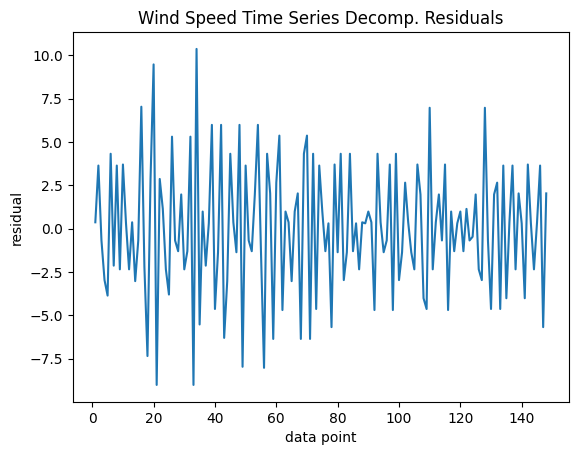

In [35]:
# Just to be sure, let's evaluate the stationarity of the residuals from the wind speed classical decomposition.
wind_decomp = seasonal_decompose(x=wind['wind_speed'], period=3, model='additive')
wind_decomp_residuals = wind_decomp.resid[1:149]
plt.title('Wind Speed Time Series Decomp. Residuals')
plt.xlabel('data point')
plt.ylabel('residual')
wind_decomp_residuals.plot()
plt.show()

In [37]:
# Checking for stationarity around a constant:
kpss_wind_decomp_residuals = kpss(wind_decomp_residuals, regression='c')
print('KPSS test: wind speed decomp. residuals around a constant')
names = ['KPSS test statistic', 'p-value', 'truncation lag parameter', 'critical values']
lzip(names, kpss_wind_decomp_residuals)

KPSS test: wind speed decomp. residuals around a constant


C:\Users\pmwad\AppData\Local\Temp\ipykernel_14904\859474191.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_wind_decomp_residuals = kpss(wind_decomp_residuals, regression='c')


[('KPSS test statistic', 0.02350266347287275),
 ('p-value', 0.1),
 ('truncation lag parameter', 5),
 ('critical values', {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})]

In [38]:
# It does appear to be stationary.
# Let's look at ADF:
adf_wind_decomp_residuals = adfuller(wind_decomp_residuals)
print('Augmented Dickey-Fuller test: wind speed decomp. residuals')
names = ['ADF test statistic', 'p-value', '# of lags used', '# observations', 'critical values', 'maximized information criterion']
lzip(names, adf_wind_decomp_residuals)

Augmented Dickey-Fuller test: wind speed decomp. residuals


[('ADF test statistic', -6.64448659160465),
 ('p-value', 5.307793241807764e-09),
 ('# of lags used', 12),
 ('# observations', 135),
 ('critical values',
  {'1%': -3.479742586699182,
   '5%': -2.88319822181578,
   '10%': -2.578319684499314}),
 ('maximized information criterion', 618.04696857202)]

In [ ]:
# And again the ADF test agrees with KPSS.